In [323]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import category_encoders as ce

from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import re
import os
sns.set_theme(style="darkgrid")

path = os.path.dirname(os.getcwd()).replace('\\', '/') + '/'


import warnings
warnings.simplefilter("ignore", UserWarning)

warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)

In [324]:
hotels_data = pd.read_csv(path + 'data_set\hotels.csv')

# Подсчитываем количество дубликатов и удаляем их 
print(f'Количество дубликатов составляет: {hotels_data.duplicated().sum()}')
hotels_data.drop_duplicates()

# Также мы можем удалить признак review_date так как у нас 
# уже есть признак days_since_review 
hotels_data = hotels_data.drop('review_date', axis=1)


Количество дубликатов составляет: 307


In [325]:
hotels_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   average_score                               386803 non-null  float64
 3   hotel_name                                  386803 non-null  object 
 4   reviewer_nationality                        386803 non-null  object 
 5   negative_review                             386803 non-null  object 
 6   review_total_negative_word_counts           386803 non-null  int64  
 7   total_number_of_reviews                     386803 non-null  int64  
 8   positive_review                             386803 non-null  object 
 9   review_total_positive_word_counts           386803 non-null  int64  
 

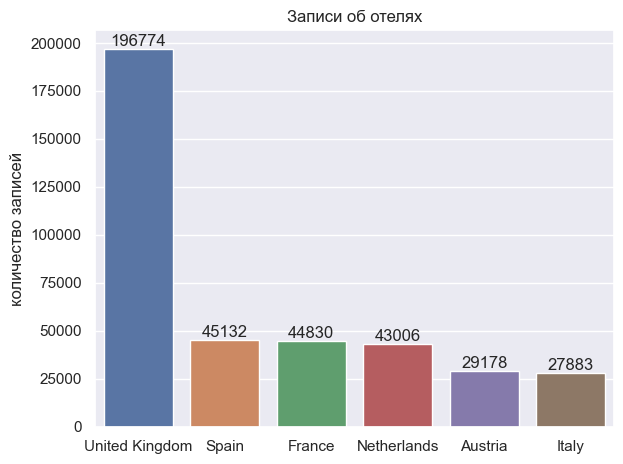

In [326]:
# Записываем категориальные признаки в отдельный датафрейм
ObjDataHotel = hotels_data[['hotel_address', 'hotel_name', 
                            'reviewer_nationality', 'negative_review', 
                            'positive_review', 'tags', 'days_since_review']]



# Из признака 'hotel_address' мы можем извлечь название страны
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_address'].apply(lambda x: x.split(' ')[-2:]) 
    
    
    
ObjDataHotel['hotel_country'] = \
    ObjDataHotel['hotel_country'].apply(lambda x: x[1] if x[0] != 'United' and \
        x[1] != 'Kingdom' else 'United Kingdom')
    
# Судя по всему в датафрейме указаны только столичные отели, поэтому 
# извлекать название города в отдельную переменную нет необходимости    
    
    
# Подсчитываем количество записей об отелях по странам и выводим ввиде барплота
HotelCntry_count = ObjDataHotel['hotel_country'].value_counts().to_frame()

HotelCntry_count.reset_index().rename(columns={'hotel_country':'hotel_country'})

HotelCntry_bar = sns.barplot(data=HotelCntry_count, x='hotel_country', 
                             y='count', hue='hotel_country', palette='deep',
                             errorbar=None)

HotelCntry_bar.set(title='Записи об отелях', 
                   ylabel='количество записей', xlabel='')


for i in HotelCntry_bar.containers:
    HotelCntry_bar.bar_label(i)
    
plt.tight_layout()


# Так как количество стран невелико (ниже 15) можно их закодировать с помощью 
# Ordinary Encoder
HotelCntry_dummies = pd.get_dummies(ObjDataHotel['hotel_country'], 
                                    prefix='hotel_',  dtype=int)

In [327]:
# Оцениваем количество уникальных значений в признаке 'hotel_name'
print(f"Количество уникальных значений hotel_name {ObjDataHotel['hotel_name'].nunique()}")
print(f"Количество уникальных значений reviewer_nationality {ObjDataHotel['reviewer_nationality'].nunique()}")



# Кодируем эту переменную с помощью Binary Encoder 
# так как уникальных значений значительно выше 15
BinEncoder = ce.BinaryEncoder(cols=['hotel_name'])
BinHotlname = BinEncoder.fit_transform(ObjDataHotel['hotel_name'])
BinHotlname


# Аналогичным образом можно закодировать 'reviewer_nationality'
BinEncoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
BinRewNation = BinEncoder.fit_transform(ObjDataHotel['reviewer_nationality'])
BinRewNation


# Признак 'days_since_review' переводим в формат int
review_days= \
    ObjDataHotel['days_since_review'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))


Количество уникальных значений hotel_name 1492
Количество уникальных значений reviewer_nationality 225


In [328]:
# Приводим все строки в переменной 'negative_review' к нижнему регистру
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
NonNegList = ObjDataHotel['negative_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()



# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с истинно-отрицательными комментариями по типу "bad wifi" 
to_find = r'nois|room|leav|pric|bed|cost|applicable|parking|gym|^.*wifi$|staff|\
    |breakfast|bathroom|everything|pool|bar|view|service|location|expensive|\
        |cleanliness|weather|pillows'

# Функция возвращает None если слово в списке to_find, 
# в противном случае возвращает строку без изменений
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0:
        return
    else:
        return string


NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(lambda x: ''.join(x.split(' ')))

NonNegList['negative_review'] = \
    NonNegList['negative_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
NonNegList.dropna(inplace=True)
NonNegList = list(set(NonNegList['negative_review']))



# Удаляем пробеды из признака 'negative_review'
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
ObjDataHotel['negative_review'] = \
    ObjDataHotel['negative_review'].apply(lambda x: 0 if x in NonNegList else 1)
    
NegRewMod = ObjDataHotel['negative_review'].to_frame()
    


In [329]:
# Аналогичны образом можно модифицировать признак 'positive_review'

# Приводим все строки в переменной 'negative_review' к нижнему регистру
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: x.lower())

# Выбираем топ 150 коментариев, среди которых ложно-отрицательные
# (по типу "No negative" или "nothing") будут всречаться наиболее часто
NonPosList = ObjDataHotel['positive_review'].value_counts()\
    .nlargest(150).to_frame().reset_index()
    


# Среди этого топа комментариев выбираем ключевые слова, которые ассоциированы
# с истинно-отрицательными комментариями по типу "bad wifi" 
to_find = r'^na|^no'


# Функция возвращает строку если слово в списке to_find, 
# в противном случае возвращает None
def FindRegEx (string):
    findlst = re.findall(to_find, string)
    if len(findlst) > 0 or string == '':
        return string
    else:
        return 
    
    
NonPosList['positive_review'] = \
    NonPosList['positive_review'].apply(lambda x: ''.join(x.split(' ')))

NonPosList['positive_review'] = \
    NonPosList['positive_review'].apply(FindRegEx)
    
    
# Удаляем None и оставляем только уникальные значения
NonPosList.dropna(inplace=True)
NonPosList = list(set(NonPosList['positive_review']))



# Удаляем пробеды из признака 'positive_review'
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: ''.join(x.split(' ')))
    

# Заменяем ложно-негативные на 0, истинно негативные на 1
ObjDataHotel['positive_review'] = \
    ObjDataHotel['positive_review'].apply(lambda x: 0 if x in NonPosList else 1)
    
PosRewMod = ObjDataHotel['positive_review'].to_frame()
    


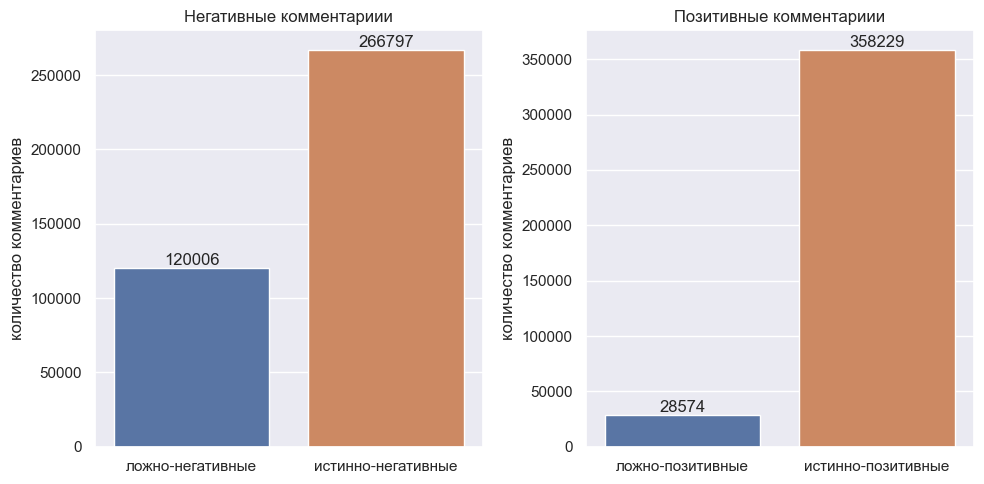

In [330]:
# Выводим в виде барплотов
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
 
    
# Барплот с негативными комментариями   
NegCom_count = ObjDataHotel['negative_review'].value_counts().to_frame()
NegCom_count.reset_index()
NegCom_count_bar = sns.barplot(data=NegCom_count, x='negative_review', ax=ax[0],
                             y='count', hue='negative_review', palette='deep',
                             errorbar=None, legend=False)

NegCom_count_bar.set(title='Негативные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-негативные', 'истинно-негативные'])


for i in NegCom_count_bar.containers:
    NegCom_count_bar.bar_label(i)
################################################################################    


# Барплот с позитивными комментариями
PosCom_count = ObjDataHotel['positive_review'].value_counts().to_frame()
PosCom_count.reset_index()
PosCom_count_bar = sns.barplot(data=PosCom_count, x='positive_review', ax=ax[1],
                             y='count', hue='positive_review', palette='deep',
                             errorbar=None, legend=False)

PosCom_count_bar.set(title='Позитивные комментариии', 
                   ylabel='количество комментариев', xlabel='',
                   xticklabels=['ложно-позитивные', 'истинно-позитивные'])

for i in PosCom_count_bar.containers:
    PosCom_count_bar.bar_label(i)
################################################################################   



fig.tight_layout()

## Извлекаем дополнительные признаки из признака 'tags'

In [ ]:
TagData = ObjDataHotel['tags'].to_frame()

# Превращаем строки в списки
TagData['tags'] = \
    TagData['tags'].apply(lambda x: re.sub(r"[\[\] ']", '', x).lower().split(','))


# Создаем признак который отражает количество тегов
TagData['TagCnt'] = TagData['tags'].apply(len)



# Создаем признак который будет отражать наличие животных у постояльцев
TagData['WithPet'] = \
    TagData['tags'].apply(lambda x: 1 if x[0] == 'withapet' else 0)


# удаляем первый элемент, если это был тип поездки
def PetDeleter(lst):
    if lst[0] == 'withapet' :
        return lst[1:] 
    else:
        return lst

TagData['tags'] = TagData['tags'].apply(PetDeleter)
################################################################################
################################################################################

# Создаем признак с типом поездки triptype
triptype_lst = ['leisuretrip', 'businesstrip'] # Список типов поездки
TagData['triptype'] = \
    TagData['tags'].apply(lambda x: x[0] if x[0] in triptype_lst else 'NoData')


# удаляем первый элемент, если это был тип поездки
def TripTypeDeleter(lst):
    if lst[0] in triptype_lst:
        return lst[1:] 
    else:
        return lst

TagData['tags'] = TagData['tags'].apply(TripTypeDeleter)
################################################################################
################################################################################

# Создаем признак с количеством людей n_people_lst
n_people_lst = ['couple', 'solotraveler', 'group']


TagData['n_people'] = \
    TagData['tags'].apply(lambda x: x[0] if x[0] in n_people_lst else 'NoData')
    

# удаляем первый элемент, если это было кол-во людей
def NPplDeleter(lst):
    if lst[0] in n_people_lst:
        return lst[1:] 
    else:
        return lst

TagData['tags'] = TagData['tags'].apply(NPplDeleter)
################################################################################
################################################################################

# Заменяем пустые списки на списки с NoData
TagData['tags'] = \
    TagData['tags'].apply(lambda x: ['NoData'] if len(x) == 0 else x)
    
# Создаем признак с детьми
withChildrn_lst = ['familywithyoungchildren', 'familywitholderchildren']

TagData['with_childrn'] = \
    TagData['tags'].apply(lambda x: x[0] if x[0] in withChildrn_lst else 'NoData')


# удаляем первый элемент, если это было кол-во людей
def ChildrnDeleter(lst):
    if lst[0] in withChildrn_lst:
        return lst[1:] 
    else:
        return lst

TagData['tags'] = TagData['tags'].apply(ChildrnDeleter)
################################################################################
################################################################################

# Заменяем пустые списки на списки с NoData
TagData['tags'] = \
    TagData['tags'].apply(lambda x: ['NoData'] if len(x) == 0 else x)
    

TagData['with_friends'] = \
    TagData['tags'].apply(lambda x: 1 if x[0] == 'travelerswithfriends' else 0)


# удаляем первый элемент, если это была информация о друзьях
def FriendsDeleter(lst):
    if lst[0] == 'travelerswithfriends':
        return lst[1:] 
    else:
        return lst
    
TagData['tags'] = TagData['tags'].apply(FriendsDeleter)
################################################################################
################################################################################

# Заменяем пустые списки на списки с NoData
TagData['tags'] = \
    TagData['tags'].apply(lambda x: ['NoData'] if len(x) == 0 else x)

# Записываем в Series информацию о способе договора
TagData['MobileSubmit'] = \
    TagData['tags'].apply(lambda x: 1 if x[-1] == 'submittedfromamobiledevice' else 0)


# удаляем первый элемент, если это было кол-во людей
def SubmitDeleter(lst):
    if lst[-1] == 'submittedfromamobiledevice':
        return lst[0:-1] 
    else:
        return lst
    
TagData['tags'] = TagData['tags'].apply(SubmitDeleter)
################################################################################
################################################################################

# Заменяем пустые списки на списки с NoData
TagData['tags'] = \
    TagData['tags'].apply(lambda x: ['NoData'] if len(x) == 0 else x)
    
# Выбираем все что начинается с 'stayed'
TagData['NightsCnt'] = \
    TagData['tags'].apply(lambda x: x[-1] if x[-1].startswith('stayed') else 0)

# В получившемся признаке оставляем только цифры 
TagData['NightsCnt'] = \
    TagData['NightsCnt'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]))

# удаляем первый элемент, если это было кол-во людей
def NightDeleter(lst):
    if lst[-1].startswith('stayed'):
        return lst[0:-1] 
    else:
        return lst
    
TagData['tags'] = TagData['tags'].apply(NightDeleter)
################################################################################
################################################################################

# Теперь в признаке Tags остался только тип комнаты (надеюсь)
TagData['roomtype'] = TagData['tags'].apply(lambda x: x[0])
TagData = TagData.drop('tags', axis=1)

IndexError: list index out of range

In [334]:
# С помощью get_dummies мы закодируем 'triptype', 'n_people', 'with_childrn'
# Удаляем колонку NoData и переименовываем оставшиеся чтобы читать было проще
triptype_data = pd.get_dummies(TagData['triptype'], dtype=int)
triptype_data = triptype_data.drop('NoData', axis=1)

triptype_data.rename(columns={'businesstrip':'business_trip',
                              'leisuretrip':'leisure_trip'},
                     inplace=True)
################################################################################



n_people_data = pd.get_dummies(TagData['n_people'], dtype=int)
n_people_data = n_people_data.drop('NoData', axis=1)

n_people_data.rename(columns={'solotraveler':'solo_traveler'},
                     inplace=True)
################################################################################



Childrn_data = pd.get_dummies(TagData['with_childrn'], dtype=int)
Childrn_data = Childrn_data.drop('NoData', axis=1)  

Childrn_data.rename(columns={'familywitholderchildren':'fmly_with_old_chldrn',
                             'familywithyoungchildren':'fmly_with_young_chldrn'},
                    inplace=True)
################################################################################


# Признак 'roomtype' кодируем с помощью BinEncoder
BinEncoder = ce.BinaryEncoder(cols=['roomtype'])
BinRooms = BinEncoder.fit_transform(TagData['roomtype'])
BinRooms

# Соединяем все в один датафрейм 
TagData_encoded = pd.concat([TagData, triptype_data, n_people_data, Childrn_data, BinRooms], axis=1)
TagData_encoded = TagData_encoded.drop(['triptype', 'n_people', 
                                        'with_childrn', 'roomtype'], axis=1)


In [333]:
# Обединяем все в один финальный датафрейм с закодированными переменными
ObjDataHotel_encoded = pd.concat([ObjDataHotel,
                                  TagData_encoded,
                                  HotelCntry_dummies,
                                  BinHotlname,
                                  BinRewNation,
                                  review_days], axis=1)
# Удаляем ненужные столбцы
ObjDataHotel_encoded =\
    ObjDataHotel_encoded.drop(['hotel_address', 'hotel_name',
                               'days_since_review', 'reviewer_nationality',
                               'tags', 'hotel_country'], axis=1)
    
ObjDataHotel_encoded

,negative_review,positive_review,WithPet,with_friends,MobileSubmit,NightsCnt,business_trip,leisure_trip,couple,group,...,hotel_name_9,hotel_name_10,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
0,1,1,0,0,1,2,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
1,1,1,0,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2,1,0,0,0,1,3,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
3,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0,0,6,1,0,1,0,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,0,1,0,0,1,2,0,1,0,1,...,1,1,0,0,0,0,0,1,0,0
386799,0,1,0,0,1,4,0,1,1,0,...,1,1,0,0,1,0,1,0,1,1
386800,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,1,1,1
386801,0,1,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
